<a href="https://colab.research.google.com/github/ncorriveau/ood_computervision/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [ ]:
import torch
from torch import nn
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil

#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
'''steps:

1.) map the images to the superclass, sublcass in a dict
2.) map superclass, sublcass to names 
2.) loop through training images and put them into appropriate folders
    we will build in a way to exclude certain sub classes here 
3.) loop through testing images and categorize the same way  
'''

data_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data'
train_zip = data_path + '/train_image.zip'
test_zip = data_path + 'test_image.zip'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''uncomment out this cell if you'd like to delete the existing train/test directories to reshape them'''
# shutil.rmtree(data_path+'/train', ignore_errors=False, onerror=None)
# shutil.rmtree(data_path+'/test', ignore_errors=False, onerror=None)


In [ ]:
def make_class_dict(path):
  '''takes class mapping csv and returns dict of {class: name}'''
  import pandas as pd
  df = pd.read_csv(path)
  return df['class'].to_dict()


super_class_names = make_class_dict(data_path + '/super_classes_mapping.csv')
sub_class_names = make_class_dict(data_path + '/sub_classes_mapping.csv')
sub_class_names

In [ ]:
def make_image_mapping(path):
  '''reads the label files and maps image names to (class, sublcass) tuples'''
  import pandas as pd
  df = pd.read_csv(path)
  df = df.set_index('image')
  df['combined'] = df.apply(lambda x: (x[0],x[1]), axis=1)
  return df['combined'].to_dict()
  
image_mappings = make_image_mapping(data_path + '/train_data.csv')
image_mappings

In [ ]:
def make_dir(root, new_dir, verbose=False):
  '''takes a given root path, and a desired directory in that path, and either confirms it exists or creates a new one'''

  data_path = Path(root)
  image_path = data_path / new_dir 
 
  if image_path.exists() and verbose:
      print(f"{image_path} directory exists.")
  else:
    if verbose:
      print(f"Did not find {image_path} directory, creating one...")
      print(f"{image_path} created")
    image_path.mkdir(parents=True, exist_ok=True)

make_dir(data_path, 'train')
make_dir(data_path, 'test')

In [ ]:
path = Path('./tmp/train_shuffle')
for dirpath, dirnames, filenames in os.walk(path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    #for file in filenames:
      

In [ ]:
#make the super class folders for training and testing 
train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'

superclass_list = pd.read_csv(data_path + '/super_classes_mapping.csv')
superclass_list = superclass_list['class'].to_list()
#print(superclass_list)
for sclass in superclass_list:
  make_dir(train_path, sclass)
  make_dir(test_path, sclass)

print(os.listdir(train_path))

['bird', 'dog', 'reptile']


In [ ]:
def create_folder_structure(zip_path, dest_path, sub_class_names, super_class_names, image_mappings, exclude_list = []):
  '''
  loops through the zip folder and creates folder structure in the dest_path of 
    super class/ 
      sub class/
    
  
    where the image is moved from the original folder to the appropiate subclass folder. 
    
    zip_path is the path to the train_image.zip folder, 
    sub_class_names, super_class_names, and image_mappings are all dictionaries 
    mapping sub class indexes to names, super class indexes to names, and images to 
    their respective super class, sub class 

    optional argument exception list where you can designate subclasses 
    you'd like to not copy over. This would be used if we want to exclude 
    training examples from our training set. 
    '''

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall('./tmp')

  path = Path('./tmp/train_shuffle')
  count = 0

  for dirpath, dirnames, images in os.walk(path):
    for image in images:
      count+=1
      if count%100 == 0:
        print(f"{count} images copied")

      if image != '.DS_Store':
        super_class, sub_class  = image_mappings[image]
        #print(super_class,sub_class)
        super_class_name = super_class_names[super_class]
        sub_class_name = sub_class_names[sub_class]
        sub_class_name = sub_class_name.replace(" ", "").split(',')[0]

        if sub_class_name not in exclude_list:
          print(f"making {sub_class_name} directory")

          #create directories if they don't already exist
          make_dir(dest_path+'/'+super_class_name, sub_class_name)

          #get path to superclass folder, subclass folder
          sub_path = dest_path+"/"+super_class_name+"/"+sub_class_name
          #print(f"super path : {super_path}\n sub path = {sub_path}")
          if Path(sub_path + "/" + image).is_dir():
            print(f"{sub_path} + "/" {image} already present")
          else:
            shutil.copy(dirpath + '/' + image, sub_path)


In [ ]:
zippath = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train_image.zip'
dest_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
create_folder_structure(zippath, dest_path, sub_class_names, super_class_names, image_mappings)

In [ ]:
zippath = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test_image.zip'
dest_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'
create_folder_structure(zippath, dest_path, sub_class_names, super_class_names, image_mappings)

# Data Augmentation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#kind've randomly created this from available transformations on pytorch, can play around with this 
#https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation

train_transforms = train_transforms = transforms.Compose([
    transforms.Resize((8, 8)),
    #transforms.RandomGrayscale(0.5),
    #transforms.RandomAdjustSharpness(2, 0.5), # adjust sharpness by a factor of 2 with prob 0.5 of it being adjusted
    transforms.RandomInvert(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # change intensity of image with max being 31 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])


In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.ToTensor()
])


In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


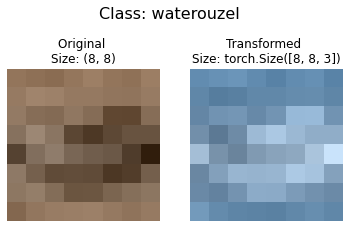

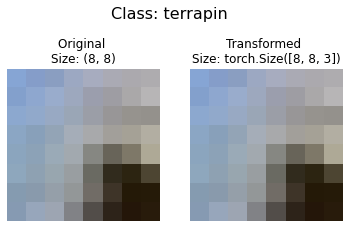

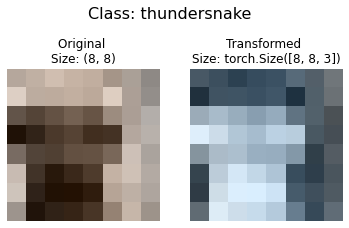

In [ ]:
#this returns a posix path to every image in our training directory 
image_paths = list(Path(train_path).glob("*/*/*.jpg"))

plot_transformed_images(image_paths, 
                        transform=train_transforms, 
                        n=3)


In [ ]:
from torchvision import datasets
train_data_super_class = datasets.ImageFolder(root=train_path, transform=train_transforms)
train_data_sub_class_dog = datasets.ImageFolder(root=train_path+'/dog', transform=train_transforms)
train_data_sub_class_reptile = datasets.ImageFolder(root=train_path+'/reptile', transform=train_transforms)
train_data_sub_class_bird = datasets.ImageFolder(root=train_path+'/bird', transform=train_transforms)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_ds_super = DataLoader(train_data_super_class, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)

train_ds_sublcass_dog =DataLoader(train_data_sub_class_dog, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)


train_ds_sublcass_bird =DataLoader(train_data_sub_class_bird, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)

train_ds_sublcass_reptile =DataLoader(train_data_sub_class_reptile, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)


In [ ]:
img_batch, label_batch = next(iter(train_ds_sublcass_reptile))
print(label_batch)